In [59]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 

### The Architecture
Rebuilding Yann Le Cuns papers: Handwritten Digit Recognitiion with a Back Propagation Network - [1989] 

The Model
- 16 * 16 Input Images -> 28 * 28 
- 4 Hidden Layers
    1. Convolutional 1: 4 feature maps with 576 units (24 * 24 feature maps) 5x5 kernel
    2. Pooling: 4 planes of 12*12 -> averaging
    3. Convolutional 2: 12 feature maps (8*8)
    4. Pooling: 12 feature maps, 4*4 plane 
- 10 Unit Output Layer

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## Visualize the data

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


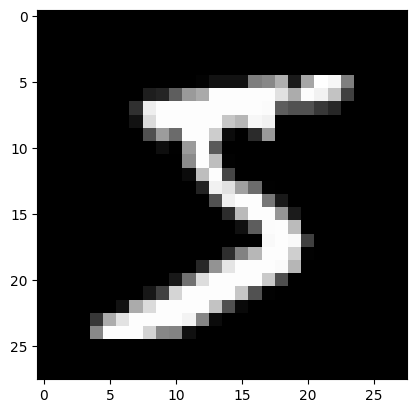

In [5]:
images, labels = next(iter(train_dataloader))

images.shape

plt.imshow(images[0].reshape(28,28), cmap="gray");

In [6]:
def conv_output_size(input_size: int, kernel_size: int, stride: int=1, padding: int=0) -> int:
    output_size = ((input_size - kernel_size + 2*padding) // stride) + 1
    return output_size



In [112]:
output = conv_output_size(input_size=28, kernel_size=5)
print(output)
output = conv_output_size(input_size=output, kernel_size=2, stride=2)
print(output)
output = conv_output_size(input_size=output, kernel_size=5)
print(output)
output = conv_output_size(input_size=output, kernel_size=2, stride=2)
print(output)
(output*output) * 12



24
12
8
4


192

In [124]:
torch.cuda.is_available(), torch.backends.mps.is_available()
device = "cpu"

class LeNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=4, kernel_size=5, stride=1, padding=1),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels = 4, out_channels=12, kernel_size=5, stride=1),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
        )
        self.flatten = nn.Flatten()

        self.fc_layer = nn.Sequential(
            nn.Linear(192, 10), # Number of pixels, number of outputs. 
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.fc_layer(x)
        return logits

model = LeNet1().to(device)
print(model)

LeNet1(
  (conv_stack): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): Tanh()
    (3): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Tanh()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layer): Sequential(
    (0): Linear(in_features=192, out_features=10, bias=True)
    (1): Sigmoid()
  )
)


In [134]:
class NetworkTrainer():

    def __init__(self, model: nn.Module, learning_rate: float = 0.01) -> None:
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        self.model = model


    def train(self, dataloader, model, loss_fn, optimizer):
        size = len(dataloader.dataset)
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def run(self, epochs: int = 5):
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            self.train(train_dataloader, self.model, self.loss_fn, self.optimizer)
            #test(test_dataloader, model, loss_fn)
        print("Done!")

NetworkTrainer(model=model, learning_rate=0.01).run(epochs=5)

Epoch 1
-------------------------------
loss: 1.780376  [   64/60000]
loss: 1.775467  [ 6464/60000]
loss: 1.747072  [12864/60000]
loss: 1.758295  [19264/60000]
loss: 1.729470  [25664/60000]
loss: 1.757061  [32064/60000]
loss: 1.719339  [38464/60000]
loss: 1.741969  [44864/60000]
loss: 1.763383  [51264/60000]
loss: 1.742507  [57664/60000]
Epoch 2
-------------------------------
loss: 1.739160  [   64/60000]
loss: 1.739158  [ 6464/60000]
loss: 1.708689  [12864/60000]
loss: 1.726284  [19264/60000]
loss: 1.702631  [25664/60000]
loss: 1.729144  [32064/60000]
loss: 1.688149  [38464/60000]
loss: 1.711325  [44864/60000]
loss: 1.733086  [51264/60000]
loss: 1.715143  [57664/60000]
Epoch 3
-------------------------------
loss: 1.712253  [   64/60000]
loss: 1.715023  [ 6464/60000]
loss: 1.684253  [12864/60000]
loss: 1.705965  [19264/60000]
loss: 1.685454  [25664/60000]
loss: 1.710947  [32064/60000]
loss: 1.666684  [38464/60000]
loss: 1.690044  [44864/60000]
loss: 1.711311  [51264/60000]
loss: 1.69

## Random Evaluation

In [1]:
image_idx = np.random.randint(64)

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Temporarily turn off gradient descent
    data = images[image_idx].unsqueeze(0).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)

print(training_data.classes[predicted[0].item()])
plt.imshow(images[image_idx].reshape(28,28), cmap="gray");

NameError: name 'np' is not defined